In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sweetviz as sv
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from imblearn.datasets import make_imbalance
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_samples, silhouette_score, f1_score
import warnings
warnings.filterwarnings("ignore")


from matplotlib import gridspec
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split,KFold, cross_val_score
from sklearn.feature_selection import RFECV
from sklearn.decomposition import PCA, KernelPCA
from sklearn import tree
from sklearn.metrics import (confusion_matrix,recall_score, make_scorer,
                    precision_score,accuracy_score,f1_score,
                    silhouette_score, completeness_score,silhouette_samples)
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans


In [7]:
bank_note = pd.read_csv('BankNote_Authentication.csv')

In [8]:
bank_note

,variance,skewness,curtosis,entropy,class
0,3.62160,8.66610,-2.8073,-0.44699,0
1,4.54590,8.16740,-2.4586,-1.46210,0
2,3.86600,-2.63830,1.9242,0.10645,0
3,3.45660,9.52280,-4.0112,-3.59440,0
4,0.32924,-4.45520,4.5718,-0.98880,0
...,...,...,...,...,...
1367,0.40614,1.34920,-1.4501,-0.55949,1
1368,-1.38870,-4.87730,6.4774,0.34179,1
1369,-3.75030,-13.45860,17.5932,-2.77710,1
1370,-3.56370,-8.38270,12.3930,-1.28230,1


In [9]:
bank_note['class'].value_counts()

0    762
1    610
Name: class, dtype: int64

In [16]:
df3 = bank_note.copy()
X = bank_note.iloc[:,:-1]
y = bank_note['class']
y = y.astype(str)

In [39]:
imbalanced_90_X, imbalanced_90_y = make_imbalance(X,y, sampling_strategy={'0':665,'1':68})
imbalanced_90_y = imbalanced_90_y.astype(int)
x3_train, x3_test, y3_train, y3_test=train_test_split(imbalanced_90_X,imbalanced_90_y, train_size=0.90, random_state=21)

In [40]:
#We check the proportions of the sets to confirm the imbalance is preserved
print("Train Shape: ", x3_train.shape)
#Class proportions
print("Train class Proportions:\n", y3_train.value_counts()/y3_train.shape)

print("Test shape: ", x3_test.shape)
#Class proportions
print("Test class Proportions:\n", y3_test.value_counts()/y3_test.shape)

Train Shape:  (659, 4)
Train class Proportions:
 0    0.908953
1    0.091047
Name: class, dtype: float64
Test shape:  (74, 4)
Test class Proportions:
 0    0.891892
1    0.108108
Name: class, dtype: float64


In [41]:
scaler=StandardScaler()
x3_train_norm=x3_train.copy()
x3_train_norm[:]=scaler.fit_transform(x3_train_norm[:])
y3_train_norm=y3_train.copy()

#normalize test set using parameters from training set.
x3_test_norm=x3_test.copy()
x3_test_norm[:]=scaler.fit_transform(x3_test_norm[:])
y3_test_norm=y3_test.copy()

Optimal number of features : 3


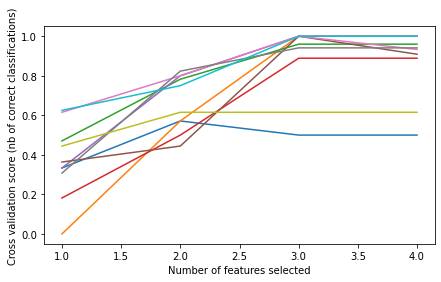

In [42]:
#Recursive Cross-Validated Feature Selection 
#We use the same folds from this point on
k_fold = KFold(n_splits=10) 
feature_selection=tree.DecisionTreeClassifier(criterion = "entropy", random_state=21)
f1_scorer=make_scorer(f1_score)
selector=RFECV(feature_selection,cv=k_fold,scoring=f1_scorer)
selector.fit(x3_train_norm,y3_train)
#keeping selected variables and printing names for control
x_best=x3_train_norm.loc[:,selector.get_support()]
xv_best=x3_test_norm.loc[:,selector.get_support()]
print("Optimal number of features : %d" % selector.n_features_)

# Plot number of features VS. cross-validation scores
fig = plt.subplots(figsize=(7,4))
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(selector.grid_scores_) + 1), selector.grid_scores_)

In [45]:
#Bootstraping mean
def boostrap_mean(sample, sample_size, n_iterations):
	bootstrap_samples=np.random.choice(sample, size=(n_iterations,sample_size), replace=True)
	mean_array=np.mean(bootstrap_samples, axis=1)
	data_mean=np.mean(mean_array)
	lower=np.percentile(mean_array,2.5)
	upper=np.percentile(mean_array,97.5)
	return data_mean, lower, upper

#Bootstraping standard deviation
def boostrap_std(sample, sample_size, n_iterations):
	bootstrap_samples=np.random.choice(sample, size=(n_iterations,sample_size), replace=True)
	std_array=np.std(bootstrap_samples, axis=1)
	data_std=np.mean(std_array)
	return data_std

#Distance function from the Total within-cluster sum of sqaures to the arch. Used during the Elbow method 
def calc_distance(x1,y1,a,b,c):
  d=abs(a*x1+b*y1+c)/((a*a+b*b)**0.5)
  return d

#permutation test: mean difference	p-value
def permutation_test(array1, array2, n_iterations):
  results=[]
  current_mean=np.mean(array1)
  new_mean=np.mean(array2)
  t_obs=new_mean-current_mean
  concat = np.concatenate((array1, array2))
  for i in range(n_iterations):    
    perm = np.random.permutation(concat)
    pcurrent= perm[:len(array1)]
    pnew= perm[len(array1):]
    t_perm=np.mean(pnew)-np.mean(pcurrent)
    if t_perm>t_obs:
      results.append(1)
    else:
      results.append(0)
  p_value=np.sum(results)/n_iterations
  return(p_value)

RF Baseline

In [46]:
#Empty lists to store results
accuracy_base=[]
f1_base=[]
g_mean_base=[]
metrics_base={"accuracy": accuracy_base, "f1": f1_base, "g-mean": g_mean_base}

#baselines
rf_base=  RandomForestClassifier(500, random_state=42)
clf=[rf_base]

#10-fold cross validation trhough each baseline
for c in clf:
  c_name=c.__class__.__name__
  print("Classifier: %s" % c_name)
  for train_indices, test_indices in k_fold.split(x3_train):
    #Train-validation split using best features
    x3_train_f=x3_train.iloc[train_indices,selector.get_support()].copy()
    x3_train_f[:]=scaler.fit_transform(x3_train_f[:])
    y3_train_f=y3_train.iloc[train_indices].copy()
    x3_val_f=x3_train.iloc[test_indices,selector.get_support()].copy()
    x3_val_f[:]=scaler.transform(x3_val_f[:])
    y3_val_f=y3_train.iloc[test_indices].copy()
  
    #training baseline
    c.fit(x3_train_f, y3_train_f)
    
    #predicting class and computing metrics
    y_hat=c.predict(x3_val_f)
    f1_f=f1_score(y3_val_f,y_hat)
    acc_f=accuracy_score(y3_val_f,y_hat)
    pr_r=precision_score(y3_val_f,y_hat)
    rec_f=recall_score(y3_val_f,y_hat)
    gmean_f=(pr_r*rec_f)**(0.5)

    #appending to results
    accuracy_base.append([acc_f,c.__class__.__name__])
    f1_base.append([f1_f,c.__class__.__name__])
    g_mean_base.append([gmean_f,c.__class__.__name__])
  
  #printing results for each baseline
  for m, v in metrics_base.items():
    mean,l,u=boostrap_mean(np.array(v)[np.array(v)[:,1]==c_name][:,0].astype(float), \
                          len(np.array(v)[np.array(v)[:,1]==c_name][:,0].astype(float)),10000)
    std=boostrap_std(np.array(v)[np.array(v)[:,1]==c_name][:,0].astype(float), \
                          len(np.array(v)[np.array(v)[:,1]==c_name][:,0].astype(float)),10000)
    print("%s \nmean: %0.4f, lower: %0.4f, upper: %0.4f, std: %0.4f " % (m,mean, l,u,std))
  print("\n")

Classifier: RandomForestClassifier
accuracy 
mean: 0.9879, lower: 0.9803, upper: 0.9939, std: 0.0106 
f1 
mean: 0.9303, lower: 0.8845, upper: 0.9719, std: 0.0645 
g-mean 
mean: 0.9336, lower: 0.8909, upper: 0.9723, std: 0.0614 




# Cluster Analysis

In [47]:
#defining maximum number of clusters
kmax=10 
#creating empty lists to store results
accuracy_cluster=[]
f1_cluster=[]
g_mean_cluster=[]
metrics_cluster={"accuracy": accuracy_cluster, "f1": f1_cluster, "g-mean": g_mean_cluster}

#10-fold CV for cluster-based method
i=1 #iterator variable
for train_indices, test_indices in k_fold.split(x3_train):
  print("Fold: %s" % i) #control message
  #Training-validation split
  x3_train_f=x3_train.iloc[train_indices,selector.get_support()].copy()
  x3_train_f[:]=scaler.fit_transform(x3_train_f[:])
  y3_train_f=y3_train.iloc[train_indices].copy()
  x3_val_f=x3_train.iloc[test_indices,selector.get_support()].copy()
  x3_val_f[:]=scaler.transform(x3_val_f[:])
  y3_val_f=y3_train.iloc[test_indices].copy()

  #####################################
  #Optimal number of clusters selection
  #####################################
  k_optimal=[]  #empty list to store results from each method
  wss=[]  #empty list for sum of squares
  silhouette_avg=[] #empty list for silhouette score

  #compute 'kmax' different clusters
  for k in range(1,kmax+1):
    kmeans = KMeans(n_clusters=k, random_state=21)  #defining algorithm
    cluster=kmeans.fit_predict(x3_train_f)  #fit kmeans
    #append silhouette score >1 as for k=1 it is not defined
    if k!=1:
      sil=silhouette_score(x3_train_f, cluster)
      silhouette_avg.append(sil)
    #append sum of squares
    wss.append(kmeans.inertia_)

  ################
  #Elbow Method
  ################
  #Rescale sum of squares
  # wss=(wss-min(wss))/(max(wss)-min(wss))

  #defining variables to compute distance from sum of squares curve
  #to the arch connecting both extremes (see plot below)
  a=wss[0]-wss[-1]
  b=list(range(1,kmax+1))[-1]-list(range(1,kmax+1))[0]
  c1=list(range(1,kmax+1))[0]*wss[-1]
  c2=list(range(1,kmax+1))[-1]*wss[0]
  c=c1-c2

  #computing distance from sum of squares curve to the arch
  distance=[]
  for k in range(kmax):
    distance.append(calc_distance(list(range(1,kmax+1))[k],wss[k],a,b,c))
  #appending optimal K based on the elbow method
  k_optimal.append(list(range(1,kmax+1))[np.argmax(distance)])

  ###################
  #Silhouette Method 
  ################## 
  #appending optimal K as that with the maximum silhouette score
  k_optimal.append(list(range(2,kmax+1))[np.argmax(silhouette_avg)])

  #choosing the max between the two methods (as it yields better results
  #than selecting the min)
  k_optimal=max(k_optimal)
  print("Best k: %s" % k_optimal) #print optimal K

  ################
  #Learning stage
  ################
  #defining kmeans algorithm
  kmeans = KMeans(n_clusters=k_optimal, random_state=21)
  cluster=kmeans.fit_predict(x3_train_f)  #fitting kmeans algorithm

  #checking whether all clusters have instances from the same class
  i2=0  #iterator
  rf={} #empty dictionary to store Random Forest classifieres
  #iterating through the clusters
  for k in range(k_optimal):
    #checking if cluster is 'complete' (instances from same class)
    if (y3_train_f[cluster==k].unique().shape[0]==1) is False:
      #defining classifier and storing it in the dictionary
      rf['rf_{0}'.format(k)] = RandomForestClassifier(500, random_state=21)
      #training classifier
      rf[list(rf.keys())[i2]].fit(x3_train_f[cluster==k],y3_train_f[cluster==k])
      i2+=1 #increasing iterator

  ##################
  #predicting Stage
  ##################
  #fitting kmeans on validation set previoulsy trained using training set
  y_hat=kmeans.predict(x3_val_f)  
  i3=0 #iterator
  #Loop through clusters to check if it has instances from the same class
  for k in range(k_optimal):
    #checking if cluster is 'complete'
    if (y3_train_f[cluster==k].unique().shape[0]==1) is True:
      #if it is complete, assign the corresponding class to the validation instances in that cluster
      y_hat[y_hat==k]=np.mean(y3_train_f[cluster==k])
    else:
      #if not use the pre-trained classifier to predict the class
      y_hat[y_hat==k]=rf[list(rf.keys())[i3]].predict(x3_val_f[y_hat==k])
      i3+=1 #increase iterator

  #computing metrics
  f1_f=f1_score(y3_val_f,y_hat)
  acc_f=accuracy_score(y3_val_f,y_hat)
  pr_r=precision_score(y3_val_f,y_hat)
  rec_f=recall_score(y3_val_f,y_hat)
  gmean_f=(pr_r*rec_f)**(0.5)

  #appending metrics to lists
  accuracy_cluster.append([acc_f,i])
  f1_cluster.append([f1_f,i])
  g_mean_cluster.append([gmean_f,i])
  i+=1 

print("\n") 
#printing results
for m, v in metrics_cluster.items():
  mean,l,u=boostrap_mean(np.array(v)[:,0].astype(float), \
                        len(np.array(v)[:,0].astype(float)),10000)
  std=boostrap_std(np.array(v)[:,0].astype(float), \
                        len(np.array(v)[:,0].astype(float)),10000)
  print("%s \nmean: %0.4f, lower: %0.4f, upper: %0.4f, std: %0.4f " % (m,mean, l,u,std))


Fold: 1
Best k: 8
Fold: 2
Best k: 10
Fold: 3
Best k: 9
Fold: 4
Best k: 10
Fold: 5
Best k: 8
Fold: 6
Best k: 8
Fold: 7
Best k: 8
Fold: 8
Best k: 10
Fold: 9
Best k: 8
Fold: 10
Best k: 8


accuracy 
mean: 0.9788, lower: 0.9561, upper: 0.9970, std: 0.0296 
f1 
mean: 0.8798, lower: 0.7786, upper: 0.9750, std: 0.1472 
g-mean 
mean: 0.8856, lower: 0.7861, upper: 0.9734, std: 0.1434 


F1 Score Mean Difference: Cluster-RF vs RandomForestClassifier:
Difference: -0.0508, p-value: 0.8060
G-mean Score Mean Difference: Cluster-RF vs RandomForestClassifier:
Difference: -0.0485, p-value: 0.7900
Accuracy Mean Difference: Cluster-RF vs RandomForestClassifier:
Difference: -0.0091, p-value: 0.7640
Best k: 10
Test accuracy: 0.9595
Test f1: 0.7692
Test g-mean: 0.7906


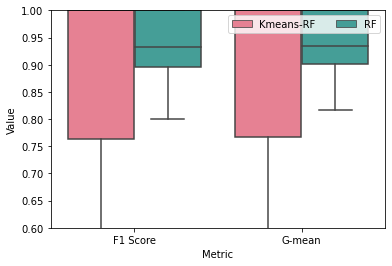

In [48]:
### A) F1 Score

base=["RandomForestClassifier"] #lists with baselines

#compare our method against baselines
for b in base:
  print("F1 Score Mean Difference: Cluster-RF vs %s:" % b)  #message
  cluster=np.array(f1_cluster)[:,0] #getting results from our method
  base=np.array(f1_base)[np.array(f1_base)[:,1]==b][:,0].astype(float) #baselines results
  diff=np.mean(cluster)-np.mean(base) #computing mean difference
  p_value=permutation_test(base,cluster,1000) #estimating p-value
  print("Difference: %0.4f, p-value: %0.4f" % (diff, p_value))  #printing p-value


### B) G-mean 

base=["RandomForestClassifier"]  #lists with baselines

#compare our method against baselines
for b in base:
  print("G-mean Score Mean Difference: Cluster-RF vs %s:" % b)  #message
  cluster=np.array(g_mean_cluster)[:,0] #getting results from our method
  base=np.array(g_mean_base)[np.array(g_mean_base)[:,1]==b][:,0].astype(float)  #baselines results
  diff=np.mean(cluster)-np.mean(base) #computing mean difference
  p_value=permutation_test(base,cluster,1000) #estimating p-value
  print("Difference: %0.4f, p-value: %0.4f" % (diff, p_value))  #printing p-value

### C) Accuracy

base=["RandomForestClassifier"]  #lists with baselines

#compare our method against baselines
for b in base:
  print("Accuracy Mean Difference: Cluster-RF vs %s:" % b)  #message
  cluster=np.array(accuracy_cluster)[:,0]  #getting results from our method
  base=np.array(accuracy_base)[np.array(accuracy_base)[:,1]==b][:,0].astype(float)  #baselines results
  diff=np.mean(cluster)-np.mean(base) #computing mean difference
  p_value=permutation_test(base,cluster,1000) #estimating p-value
  print("Difference: %0.4f, p-value: %0.4f" % (diff, p_value))  #printing p-value

#converting results to data frames to plot them

m_t=pd.DataFrame([])  #empty data frame
#iterating through cluster-based method results
for m, v in metrics_cluster.items():
  if m!="accuracy":
    m_i=pd.DataFrame(v) #converting results to dataframe
    m_i["metric"]=m #adding results
    m_i.iloc[:,1]="cluster" #indicator column
    m_t=pd.concat([m_t,m_i], ignore_index=True) #appending to empy dataframe

#iterating through baseline results
for m, v in metrics_base.items():
  if m!="accuracy":
    m_i=pd.DataFrame(v) #converting results to dataframe
    m_i["metric"]=m  #adding results
    m_t=pd.concat([m_t,m_i], ignore_index=True) #appending to empy dataframe
 

#Plotting results
plot=sns.boxplot(m_t.iloc[:,2],m_t.iloc[:,0],  hue=m_t.iloc[:,1],
                 data=m_t, palette="husl")
handles, _ = plot.get_legend_handles_labels()

plt.legend( title="", fontsize='small', fancybox=True)
plot.legend(handles, ["Kmeans-RF", "RF"],ncol=3)
plot.set(xlabel='Metric', ylabel='Value') #labeling axis
plot.set_ylim((.6,1))
plot.set_xticks(range(m_t.iloc[:,2].unique().shape[0])) 
plot.set_xticklabels(["F1 Score", "G-mean"])
plt.savefig("cancer_box.png", bbox_inches='tight') #saving figure


### 5. Test Set Results

#####################################
#Optimal number of clusters selection
#####################################
k_optimal=[]  #empty list to store results from each method
wss=[]  #empty list for sum of squares
silhouette_avg=[] #empty list for silhouette score
#Iterating thorugh the maximum number of clusters to be tested
for k in range(1,kmax+1):
  kmeans = KMeans(n_clusters=k, random_state=21)
  cluster=kmeans.fit_predict(x_best)
  if k!=1:
      sil=silhouette_score(x_best, cluster)
      silhouette_avg.append(sil)
  wss.append(kmeans.inertia_)

#Elbow Method
#Rescale sum of squares
# wss=(wss-min(wss))/(max(wss)-min(wss))

#defining variables to compute distance from sum of squares curve
#to the arch connecting both extremes (see plot below)
a=wss[0]-wss[-1]
b=list(range(1,kmax+1))[-1]-list(range(1,kmax+1))[0]
c1=list(range(1,kmax+1))[0]*wss[-1]
c2=list(range(1,kmax+1))[-1]*wss[0]
c=c1-c2

#computing distance from sum of squares curve to the arch
distance=[]
for k in range(kmax):
  distance.append(calc_distance(list(range(1,kmax+1))[k],wss[k],a,b,c))

#appending optimal K based on the elbow method
k_optimal.append(list(range(1,kmax+1))[np.argmax(distance)])

###################
#Silhouette Method 
################## 
#appending optimal K as that with the maximum silhouette score
k_optimal.append(list(range(2,kmax+1))[np.argmax(silhouette_avg)])

#choosing the max between the two methods (as it yields better results
#than selecting the min)
k_optimal=max(k_optimal)
print("Best k: %s" % k_optimal) #print optimal K

################
#Learning stage
################
#defining kmeans algorithm
kmeans = KMeans(n_clusters=k_optimal, random_state=21)
cluster=kmeans.fit_predict(x_best)

#checking whether all clusters have instances from the same class
i2=0  #iterator
rf={} #empty dictionary to store Random Forest classifieres
#iterating through the clusters
for k in range(k_optimal):
  #checking if cluster is 'complete' (instances from same class)
  if (y3_train[cluster==k].unique().shape[0]==1) is False:
    #defining classifier and storing it in the dictionary
    rf['rf_{0}'.format(k)] = RandomForestClassifier(500, random_state=21)
    #training classifier
    rf[list(rf.keys())[i2]].fit(x_best[cluster==k],y3_train[cluster==k])
    i2+=1

##################
#predicting Stage
##################
#fitting kmeans on validation set previoulsy trained using training set
y_hat=kmeans.predict(xv_best)
i3=0 #iterator
#Loop through clusters to check if it has instances from the same class
for k in range(k_optimal):
  #checking if cluster is 'complete'
  if (y3_train[cluster==k].unique().shape[0]==1) is True:
    #if it is complete, assign the corresponding class to the validation instances in that cluster
    y_hat[y_hat==k]=np.mean(y3_train[cluster==k])
  else:
    #if not use the pre-trained classifier to predict the class
    y_hat[y_hat==k]=rf[list(rf.keys())[i3]].predict(xv_best[y_hat==k])
    i3+=1

#computing metrics
f1_t=f1_score(y3_test,y_hat)
acc_t=accuracy_score(y3_test,y_hat)
pr_t=precision_score(y3_test,y_hat)
rec_t=recall_score(y3_test,y_hat)
gmean_t=(pr_t*rec_t)**(0.5)

#pritning results
metrics_test={"accuracy": acc_t, "f1": f1_t, "g-mean": gmean_t}
for m, v in metrics_test.items():
  print("Test %s: %0.4f" % (m,v))


In [49]:
#####################################
#Optimal number of clusters selection
#####################################
k_optimal=[]  #empty list to store results from each method
wss=[]  #empty list for sum of squares
silhouette_avg=[] #empty list for silhouette score
#Iterating thorugh the maximum number of clusters to be tested
for k in range(1,kmax+1):
  kmeans = KMeans(n_clusters=k, random_state=21)
  cluster=kmeans.fit_predict(x_best)
  if k!=1:
      sil=silhouette_score(x_best, cluster)
      silhouette_avg.append(sil)
  wss.append(kmeans.inertia_)

#Elbow Method
#Rescale sum of squares
# wss=(wss-min(wss))/(max(wss)-min(wss))

#defining variables to compute distance from sum of squares curve
#to the arch connecting both extremes (see plot below)
a=wss[0]-wss[-1]
b=list(range(1,kmax+1))[-1]-list(range(1,kmax+1))[0]
c1=list(range(1,kmax+1))[0]*wss[-1]
c2=list(range(1,kmax+1))[-1]*wss[0]
c=c1-c2

#computing distance from sum of squares curve to the arch
distance=[]
for k in range(kmax):
  distance.append(calc_distance(list(range(1,kmax+1))[k],wss[k],a,b,c))

#appending optimal K based on the elbow method
k_optimal.append(list(range(1,kmax+1))[np.argmax(distance)])

###################
#Silhouette Method 
################## 
#appending optimal K as that with the maximum silhouette score
k_optimal.append(list(range(2,kmax+1))[np.argmax(silhouette_avg)])

#choosing the max between the two methods (as it yields better results
#than selecting the min)
k_optimal=max(k_optimal)
print("Best k: %s" % k_optimal) #print optimal K

################
#Learning stage
################
#defining kmeans algorithm
kmeans = KMeans(n_clusters=k_optimal, random_state=21)
cluster=kmeans.fit_predict(x_best)

#checking whether all clusters have instances from the same class
i2=0  #iterator
rf={} #empty dictionary to store Random Forest classifieres
#iterating through the clusters
for k in range(k_optimal):
  #checking if cluster is 'complete' (instances from same class)
  if (y3_train[cluster==k].unique().shape[0]==1) is False:
    #defining classifier and storing it in the dictionary
    rf['rf_{0}'.format(k)] = RandomForestClassifier(500, random_state=21)
    #training classifier
    rf[list(rf.keys())[i2]].fit(x_best[cluster==k],y3_train[cluster==k])
    i2+=1

##################
#predicting Stage
##################
#fitting kmeans on validation set previoulsy trained using training set
y_hat=kmeans.predict(xv_best)
i3=0 #iterator
#Loop through clusters to check if it has instances from the same class
for k in range(k_optimal):
  #checking if cluster is 'complete'
  if (y3_train[cluster==k].unique().shape[0]==1) is True:
    #if it is complete, assign the corresponding class to the validation instances in that cluster
    y_hat[y_hat==k]=np.mean(y3_train[cluster==k])
  else:
    #if not use the pre-trained classifier to predict the class
    y_hat[y_hat==k]=rf[list(rf.keys())[i3]].predict(xv_best[y_hat==k])
    i3+=1

#computing metrics
f1_t=f1_score(y3_test,y_hat)
acc_t=accuracy_score(y3_test,y_hat)
pr_t=precision_score(y3_test,y_hat)
rec_t=recall_score(y3_test,y_hat)
gmean_t=(pr_t*rec_t)**(0.5)

#pritning results
metrics_test={"accuracy": acc_t, "f1": f1_t, "g-mean": gmean_t}
for m, v in metrics_test.items():
  print("Test %s: %0.4f" % (m,v))



Best k: 10
Test accuracy: 0.9595
Test f1: 0.7692
Test g-mean: 0.7906
